In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('precision', 2)

In [2]:
def generate_data(predictions_path):

    with open(predictions_path) as f:
        predictions = f.readlines()

    data = []

    for prediction in predictions:
        prediction = json.loads(prediction)
        d = {}

        gold_spans = prediction['maximizing_ground_truth']['spans']
        if len(gold_spans) > 0:
            d['n_gold_spans'] = len(gold_spans)
        else:
            continue

        predicted_spans = prediction['answer']['value']
        if len(predicted_spans) > 0:
            if isinstance(predicted_spans, list):  # multi-span prediction
                d['n_pred_spans'] = len(predicted_spans)
            elif isinstance(predicted_spans, str):  # single-span prediction
                d['n_pred_spans'] = 1
            else:
                raise Exception(f"unexpected span perdiction: {predicted_spans}")

        d['query_id'] = prediction['query_id']
        d['head_used'] = prediction['predicted_ability']
        d['em'] = prediction['em'] * 100
        d['f1'] = prediction['f1'] * 100

        data.append(d)

    df = pd.DataFrame(data)
    df = df.set_index('query_id')
    return df

In [3]:
def metrics_by_gold_spans(df):
    gb = df.groupby('n_gold_spans').agg(count=('n_gold_spans', 'size'), em=('em', 'mean'), f1=('f1', 'mean'))
    gb['ratio'] = (gb['count'] / gb['count'].sum() * 100)
    gb = gb[['count', 'ratio', 'f1', 'em']]
    return gb

def predicted_spans_by_gold_spans(df):
    gb = df.groupby('n_gold_spans').agg(count=('n_gold_spans', 'size'), mean_pred_spans=('n_pred_spans', 'mean'), std_pred_spans=('n_pred_spans', 'std'))
    gb['ratio'] = (gb['count'] / gb['count'].sum() * 100)
    gb = gb[['count', 'ratio', 'mean_pred_spans', 'std_pred_spans']]
    return gb

def division_of_labor(df):
    gb = df.groupby(['n_gold_spans', 'head_used']).agg(count=('n_gold_spans', 'size'), f1=('f1', 'mean'), em=('em', 'mean'))
    return gb

def plot_metrics_by_gold_spans(df, filename=None, max_spans=4):
    df = metrics_by_gold_spans(df)
    
    x = df.index.values[:max_spans]
    f1 = df['f1'][:max_spans]
    em = df['em'][:max_spans]
    counts = df['count'][:max_spans]
    
    width = 0.25  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, f1, width, label='F1')
    rects2 = ax.bar(x + width/2, em, width, label='EM')

    ax.set_facecolor('lavender')
    ax.set_ylabel('Performance', fontsize=16)
    ax.set_xlabel('# Gold Spans', fontsize=16)
    ax.set_xticks(x)
    
    # a hack so the annotation will be within the figure
    ax.set_ylim(top=ax.get_ylim()[1] + 6)  

    # ax.set_title('Title')
    ax.legend(loc='lower right')
    
    # annotate (assume f1 is always taller...)
    for rect, count in zip(rects1, counts):
        ax.annotate(f'{count}',
                    xy=(rect.get_x() + rect.get_width(), rect.get_height()),
                    xytext=(0, 7),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    bbox=dict(facecolor='whitesmoke', edgecolor='black', boxstyle='round')
                    )
    fig.tight_layout()
    if filename is not None:
        plt.savefig(fname=filename, format='pdf')
    plt.show()

In [4]:
def plot_combined_data(df, filename=None, max_spans=4):
    mean_pred_spans = predicted_spans_by_gold_spans(df)['mean_pred_spans'].round(2)
    df = metrics_by_gold_spans(df)
    
    x = df.index.values[:max_spans]
    f1 = df['f1'][:max_spans]
    em = df['em'][:max_spans]
    counts = df['count'][:max_spans]
    
    width = 0.25  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, f1, width, label='F1')
    rects2 = ax.bar(x + width/2, em, width, label='EM')

    ax.set_facecolor('lavender')
    ax.set_ylabel('Performance', fontsize=16)
    ax.set_xlabel('# Gold Spans', fontsize=16)
    ax.set_xticks(x)
    
    # a hack so the annotation will be within the figure
    ax.set_ylim(top=ax.get_ylim()[1] + 6)  

    # ax.set_title('Title')
    ax.legend(loc='center right')
    
    # annotate (assume f1 is always taller...)
    for rect, count, mean_pred in zip(rects1, counts, mean_pred_spans):
        ax.annotate(f'{count}',
                    xy=(rect.get_x() + rect.get_width(), rect.get_height()),
                    xytext=(0, 1),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    bbox=dict(facecolor='whitesmoke', edgecolor='black', boxstyle='circle')
                    )
        ax.annotate(f'{mean_pred}',
                    xy=(rect.get_x() + rect.get_width(), 5),
                    ha='center', va='bottom',
                    bbox=dict(facecolor='whitesmoke', edgecolor='black', boxstyle='round4')
                    )
    fig.tight_layout()
    if filename is not None:
        plt.savefig(fname=filename, format='pdf')
    plt.show()

## DROP All Heads

In [5]:
df = generate_data('model30b_10.jsonl')

### Metrics By Gold Spans

In [6]:
metrics_by_gold_spans(df)

,count,ratio,f1,em
n_gold_spans,,,,
1,2996,85.43,87.69,82.54
2,336,9.58,79.75,58.93
3,103,2.94,81.36,54.37
4,47,1.34,86.62,68.09
5,17,0.48,66.53,29.41
6,5,0.14,65.20,0.00
7,1,0.03,86.00,0.00
8,1,0.03,38.00,0.00
9,1,0.03,44.00,0.00


### Predicted Spans By Gold Spans

In [7]:
predicted_spans_by_gold_spans(df)

,count,ratio,mean_pred_spans,std_pred_spans
n_gold_spans,,,,
1,2996,85.43,1.01,0.14
2,336,9.58,2.15,0.69
3,103,2.94,2.88,0.72
4,47,1.34,3.64,0.79
5,17,0.48,4.24,1.68
6,5,0.14,4.60,2.19
7,1,0.03,6.00,NaN
8,1,0.03,3.00,NaN
9,1,0.03,4.00,NaN


### Division of Labor Between Heads

In [8]:
# division_of_labor(df)

## DROP Only Multi Head

In [9]:
df = generate_data('model38_12.jsonl')

### Metrics By Gold Spans

In [10]:
metrics_by_gold_spans(df)

,count,ratio,f1,em
n_gold_spans,,,,
1,2994,85.47,86.55,81.50
2,338,9.65,79.86,59.76
3,100,2.85,76.53,48.00
4,50,1.43,87.10,68.00
5,15,0.43,62.67,26.67
6,3,0.09,88.67,0.00
7,1,0.03,86.00,0.00
8,1,0.03,38.00,0.00
9,1,0.03,56.00,0.00


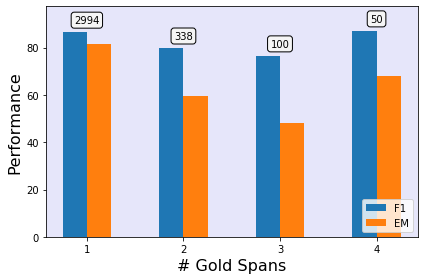

In [11]:
plot_metrics_by_gold_spans(df, filename='model38_12_fig_n_gold_spans.pdf')

### Predicted Spans By Gold Spans

In [12]:
predicted_spans_by_gold_spans(df)

,count,ratio,mean_pred_spans,std_pred_spans
n_gold_spans,,,,
1,2994,85.47,1.02,0.14
2,338,9.65,1.95,0.55
3,100,2.85,2.65,0.81
4,50,1.43,3.62,0.85
5,15,0.43,4.13,1.77
6,3,0.09,6.33,0.58
7,1,0.03,6.00,NaN
8,1,0.03,3.00,NaN
9,1,0.03,5.00,NaN


### Combined Plot for Paper

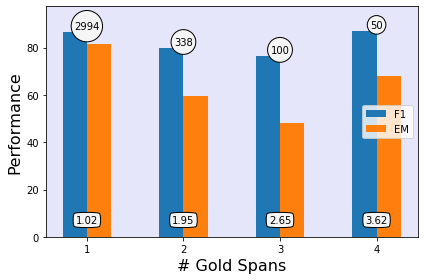

In [13]:
plot_combined_data(df, filename='model38_12_fig_combined.pdf')

## Quoref All Heads

In [14]:
df = generate_data('model43_2.jsonl')

### Metrics By Gold Spans

In [15]:
metrics_by_gold_spans(df)

,count,ratio,f1,em
n_gold_spans,,,,
1,2197,90.86,84.63,80.93
2,145,6.00,82.02,67.59
3,51,2.11,79.65,50.98
4,12,0.50,87.50,58.33
5,6,0.25,53.33,0.00
6,2,0.08,84.00,0.00
7,2,0.08,48.50,0.00
8,3,0.12,33.33,33.33


### Predicted Spans By Gold Spans

In [16]:
predicted_spans_by_gold_spans(df)

,count,ratio,mean_pred_spans,std_pred_spans
n_gold_spans,,,,
1,2197,90.86,1.02,0.23
2,145,6.00,1.93,0.51
3,51,2.11,2.96,0.72
4,12,0.50,3.75,0.45
5,6,0.25,3.17,1.17
6,2,0.08,6.50,0.71
7,2,0.08,4.00,4.24
8,3,0.12,3.33,4.04


### Division of Labor Between Heads

In [17]:
# division_of_labor(df)

## Quoref Only Multi Head

In [18]:
df = generate_data('model44_3.jsonl')

### Metrics By Gold Spans

In [19]:
metrics_by_gold_spans(df)

,count,ratio,f1,em
n_gold_spans,,,,
1,2197,90.86,85.29,81.20
2,145,6.00,78.54,61.38
3,51,2.11,77.04,49.02
4,12,0.50,89.58,58.33
5,6,0.25,73.33,50.00
6,2,0.08,65.50,0.00
7,2,0.08,28.50,0.00
8,3,0.12,33.33,33.33


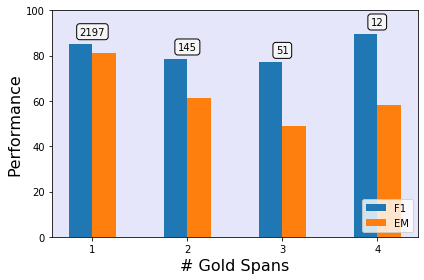

In [20]:
plot_metrics_by_gold_spans(df, filename='model44_3_fig_n_gold_spans.pdf')

### Predicted Spans By Gold Spans

In [21]:
predicted_spans_by_gold_spans(df)

,count,ratio,mean_pred_spans,std_pred_spans
n_gold_spans,,,,
1,2197,90.86,1.03,0.21
2,145,6.00,1.94,0.71
3,51,2.11,2.96,0.87
4,12,0.50,3.83,0.39
5,6,0.25,4.33,1.21
6,2,0.08,5.50,2.12
7,2,0.08,2.50,2.12
8,3,0.12,3.33,4.04
